In [32]:
SAVE = True

VERSION = 'Empirical Covariance' #'Empirical Covariance'  # 'Pseudoinverse', 'Gaussian Obs Model'

In [2]:
import sys
sys.path.append('..')
import data_utils
sys.path.append(data_utils.join_base_path('reallaborai4u/preprocessing'))
from feature_names import NON_CONDITIONAL_FEAT as LABELS
from feature_names import INTERACTIVE_NAMES, INTERVENTION_NAMES_EN
PRINT_LABELS = [l.removeprefix('EMA_') for l in LABELS]

Find the proximal effects of each intervention on each EMA, and additionally the number of missings

In [3]:
import pandas as pd
import numpy as np
from typing import Optional
import sys
sys.path.append('..')

def get_proximal_effects(data: pd.DataFrame, from_timestep: Optional[int]=None, until_timestep: Optional[int]=None,
                         sum_over_emas: bool=True, binned_policy: str='ignore'):
    
    if binned_policy == 'ignore':
        data.loc[data['Form'] == 'binned', LABELS] = np.nan
    elif binned_policy == 'drop':
        data = data.loc[data['Form'] != 'binned']
    diff = data.set_index(['Participant'], append=True)
    diff = data[LABELS].diff().shift(-1)
    diff[INTERACTIVE_NAMES] = data[INTERACTIVE_NAMES]
    diff = diff.dropna()
    diff = diff.loc[diff[INTERACTIVE_NAMES].sum(axis=1)>0]
    if from_timestep is not None:
        diff = diff.loc[from_timestep:]
    if until_timestep is not None:
        diff = diff.loc[:until_timestep]
    EMI_occurrence = diff[INTERACTIVE_NAMES].sum().astype(int)
    EMI_occurrence[EMI_occurrence==0] = 1
    # Get the sum of effects of each intervention on each EMA
    sum_effects = diff[LABELS].T.dot(diff[INTERACTIVE_NAMES])
    # Normalize them by the number of intervention presentations
    sum_effects = sum_effects.div(EMI_occurrence)
    if sum_over_emas:
        sum_effects = sum_effects.mean()
    return sum_effects, EMI_occurrence

Calculate proximal effects

In [4]:
import sys
sys.path.append('..')
from tqdm import tqdm
import pandas as pd
import data_utils

MRT = [2, 3]
effects = []
emi_occurrences = []

for mrt in MRT:

    mrt_effects = []
    mrt_emi_occurrences = []
    test_data_dir = data_utils.dataset_path(mrt, 'processed_csv_no_con')
    data_files = data_utils.get_data_files(test_data_dir)
    participants = data_utils.get_participant_ids(data_files)
    dist = {}
    for p, df in tqdm(data_utils.zip_participants_data(test_data_dir), total=len(participants), desc=f'Calculating proximal effects for MRT {mrt}'):    
        participant_effects = []
        for binned_policy in ['ignore', 'drop', 'none']:
            pe, participant_emi_occurrences = get_proximal_effects(df, binned_policy=binned_policy)
            participant_effects.append(pe)
        participant_effects = pd.concat(participant_effects, axis=1, keys=['ignore', 'drop', 'none'], names=['binned_policy']).T
        participant_effects['participant'] = p
        # participant_emi_occurrences['participant'] = p
        mrt_effects.append(participant_effects)
        mrt_emi_occurrences.append(participant_emi_occurrences)
    mrt_effects = pd.concat(mrt_effects, axis=0).set_index('participant', append=True)
    effects.append(mrt_effects)
    mrt_emi_occurrences = pd.concat(mrt_emi_occurrences, axis=1, keys=participants, names=['participant']).T
    emi_occurrences.append(mrt_emi_occurrences)
effects = pd.concat(effects, axis=0, keys=MRT, names=['MRT']).sort_index()
emi_occurrences = pd.concat(emi_occurrences, axis=0, keys=MRT, names=['MRT']).sort_index()

Calculating proximal effects for MRT 3: 100%|██████████| 59/59 [00:01<00:00, 41.71it/s]


Calculate CIRs with latest model ensembles

In [5]:
import sys
sys.path.append('..')
from tqdm import tqdm
import torch as tc
import pandas as pd
import eval_reallabor_utils
import data_utils
import utils
from bptt.plrnn import PLRNN

MRT = [2, 3]
plrnn_emi_cir = []
errors_loading_model = 0
ModelClass = PLRNN

for mrt in MRT:

    mrt_cir = []

    results_dir = data_utils.join_ordinal_bptt_path('results', f'v3_MRT{mrt}_every_day')
    test_data_dir = data_utils.dataset_path(mrt, 'processed_csv_no_con')

    models = eval_reallabor_utils.ModelCatalogue(results_dir, only_valid_days=False)
    data_files = data_utils.get_data_files(test_data_dir)
    participants = data_utils.get_participant_ids(data_files)
    dist = {}
    for p, df in tqdm(data_utils.zip_participants_data(test_data_dir), total=len(participants), desc=f'Calculating Impulse Responses for MRT {mrt}'):            
        model_dirs = models.get_latest_model_dirs(p, 1000)
        participant_cir = []
        for model_dir in model_dirs:
            model_cir = []
            args = utils.load_args(model_dir)
            model = ModelClass(args)
            model.init_from_model_path(model_dir)
            try:
                Gamma, B = eval_reallabor_utils.get_Gamma_and_B(model, model_dir, version=VERSION)
            except:
                errors_loading_model += 1
                continue
            dim_x, dim_s = args['dim_x'], args['dim_s']
            
            for x0 in [tc.tensor(df[LABELS].to_numpy()).float(),
                        tc.tensor(df.loc[df[INTERACTIVE_NAMES].sum(axis=1)>0, LABELS].to_numpy()).float(),
                        tc.cat((tc.eye(dim_x).float(), tc.zeros(dim_x).float().unsqueeze(0)), 0)]:
                cir = tc.zeros(dim_s)
                for i in range(dim_s):
                    perturbation = tc.zeros(dim_s).float()
                    perturbation[i] = 1
                    cir[i] = tc.nanmean(eval_reallabor_utils.impulse_response(model, perturbation, 1, cumulative=True, relative=True, x0=x0, Gamma=Gamma, B=B))
                model_cir.append(cir.detach().numpy())
            model_cir = pd.DataFrame(model_cir, columns=INTERACTIVE_NAMES, index=['all', 'emi', 'unit'])
            model_cir['timestep'] = int(float(args['train_on_data_until_timestep']))
            model_cir.index.name = 'x0'
            participant_cir.append(model_cir)
        if len(participant_cir) == 0:
            continue
        participant_cir_df = pd.concat(participant_cir, axis=0)            
        participant_cir_df = pd.concat([participant_cir_df.groupby('x0').mean(numeric_only=True),            # Mean over all models
                                        participant_cir_df.loc[participant_cir_df['timestep']==participant_cir_df['timestep'].max()]],  # just the last model
                                        axis=0, keys=['all', 'last'], names=['model'])
        participant_cir_df['participant'] = int(p)
        participant_cir_df = participant_cir_df.set_index(['participant'], append=True)[INTERACTIVE_NAMES]
        mrt_cir.append(participant_cir_df)
    mrt_cir = pd.concat(mrt_cir, axis=0)
    plrnn_emi_cir.append(mrt_cir)
plrnn_emi_cir = pd.concat(plrnn_emi_cir, axis=0, keys=MRT, names=['MRT']).sort_index()

if errors_loading_model > 0:
    print(f"Warning: {errors_loading_model} errors loading Gamma and B.")

Calculating Impulse Responses for MRT 3: 100%|██████████| 59/59 [00:34<00:00,  1.72it/s]

Plot rank correlations histogram

Dropped [73]
MRT2, percent >0.5: 30.909090909090907
      percent >0.3: 21.818181818181817
     percent >0.1: 10.909090909090908
Group-wise correlation: 0.253, 95% CI [0.138, 0.361], p=0.000
Group-wise correlation 2: 0.253, 95% CI [0.122, 0.373], p=0.001
Group-wise correlation 3: 0.253, 95% CI [0.035, 0.659], p=0.030
MRT3, percent >0.5: 30.508474576271187
      percent >0.3: 23.728813559322035
     percent >0.1: 16.94915254237288
Group-wise correlation: 0.327, 95% CI [0.222, 0.425], p=0.000
Group-wise correlation 2: 0.327, 95% CI [0.223, 0.429], p=0.000
Group-wise correlation 3: 0.327, 95% CI [0.163, 0.700], p=0.002
Overall percent >0.5: 30.973451327433626
Overall percent >0.3: 23.008849557522122
Overall percent >0.1: 14.15929203539823


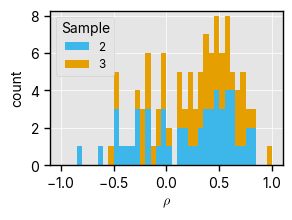

In [ ]:
import sys
sys.path.append('..')
import pandas as pd
import matplotlib.pyplot as plt
from plotting_styles import PaperStyle, colors
import plotting_utils
from weighted_correlation import weight_corr_for_dataframes, meta_spearman, participant_bootstrap_pooled_corr, hierarchical_bootstrap_pooled_corr, weighted_spearman

select_model = 'all'
select_binned_policy = 'ignore'
select_x0 = 'all'

with PaperStyle():

    fig, ax = plt.subplots(1, 1, figsize=(3,2))
    joint_correlations = []
    
    for m, mrt in enumerate(MRT):
        
        plrnn_emi_rank = plrnn_emi_cir.loc[(mrt, select_model, select_x0)]
        effects_rank = effects.loc[(mrt, select_binned_policy)]
        effects_rank = effects_rank.loc[plrnn_emi_rank.index]
        correlations = weight_corr_for_dataframes(plrnn_emi_rank, effects_rank, emi_occurrences.loc[mrt].loc[plrnn_emi_rank.index], method='spearman', axis=1, B=1, alternative='greater', 
                                                  p_method='permutation', ci_type='percentile', clip_ci=True)
        joint_correlations.append(correlations['statistic'])
    
        participant_order = correlations.sort_values(by='statistic').dropna().index
        dropped = correlations.loc[correlations['statistic'].isna()].index.to_list()

        if len(dropped) > 0:
            print(f'Dropped {dropped}')

        print(f'MRT{mrt}, percent >0.5: {100*(correlations['statistic']>0.5).mean()}')
        print(f'      percent >0.3: {100*((correlations['statistic']>0.3) & (correlations['statistic']<=0.5)).mean()}')
        print(f'     percent >0.1: {100*((correlations['statistic']>0.1) & (correlations['statistic']<=0.3)).mean()}')

        overall_effect = meta_spearman(correlations['statistic'].dropna(), None)
        overall_effect2 = participant_bootstrap_pooled_corr(correlations['statistic'].dropna())
        overall_effect3 = hierarchical_bootstrap_pooled_corr(plrnn_emi_rank.to_numpy(), effects_rank.to_numpy(), emi_occurrences.loc[mrt].loc[plrnn_emi_rank.index].to_numpy(), weighted_spearman, B_outer=10000, seed=1)

        print(f'Group-wise correlation: {overall_effect['effect']:.3f}, 95% CI [{overall_effect['ci_lower']:.3f}, {overall_effect['ci_upper']:.3f}], p={overall_effect['p']:.3f}')
        print(f'Group-wise correlation 2: {overall_effect2['pooled_effect']:.3f}, 95% CI [{overall_effect2['ci_lower']:.3f}, {overall_effect2['ci_upper']:.3f}], p={overall_effect2['p_value']:.3f}')
        print(f'Group-wise correlation 3: {overall_effect3['pooled_effect']:.3f}, 95% CI [{overall_effect3['ci_lower']:.3f}, {overall_effect3['ci_upper']:.3f}], p={overall_effect3['p_value']:.3f}')
        
    joint_correlations = pd.concat(joint_correlations, axis=1, keys=MRT, names=['Sample']).astype(float)
    joint_correlations.plot(ax=ax, kind='hist', ylabel='count', xlabel=r'$\rho$', bins=np.arange(-1, 1.05, 0.05), stacked=True)
    plotting_utils.adjust_ylim(ax, top=0.03, bottom=0.0)
    if SAVE:
            plt.savefig(data_utils.join_ordinal_bptt_path('results', '_paper', f'emi_rank_correlation_histogram.svg'))

    print(f'Overall percent >0.5: {100*(joint_correlations.stack()>0.5).mean()}')
    print(f'Overall percent >0.3: {100*((joint_correlations.stack()>0.3) & (joint_correlations.stack()<=0.5)).mean()}')
    print(f'Overall percent >0.1: {100*((joint_correlations.stack()>0.1) & (joint_correlations.stack()<=0.3)).mean()}')
    plt.show()

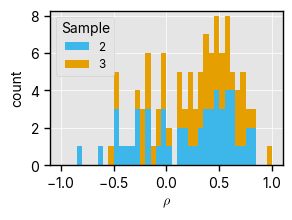

In [7]:
with PaperStyle():
    fig, ax = plt.subplots(1, 1, figsize=(3,2))
    joint_correlations.plot(ax=ax, kind='hist', ylabel='count', xlabel=r'$\rho$', bins=np.arange(-1, 1.05, 0.05), stacked=True)
    plotting_utils.adjust_ylim(ax, top=0.03, bottom=0.0)
    plt.show()
    # plt.savefig(data_utils.join_ordinal_bptt_path('results', '_paper', f'emi_rank_correlation_histogram.svg'))

Analyze the change in total rank correlation when subjects with few samples are iteratively excluded

ANOVA results for Sample 2:
               df     sum_sq   mean_sq         F  PR(>F)
C(min_EMI)    9.0   0.033453  0.003717  0.020884     1.0
Residual    292.0  51.970656  0.177982       NaN     NaN
ANOVA results for Sample 3:
               df     sum_sq   mean_sq         F    PR(>F)
C(min_EMI)    9.0   0.693428  0.077048  0.599708  0.797049
Residual    297.0  38.157137  0.128475       NaN       NaN


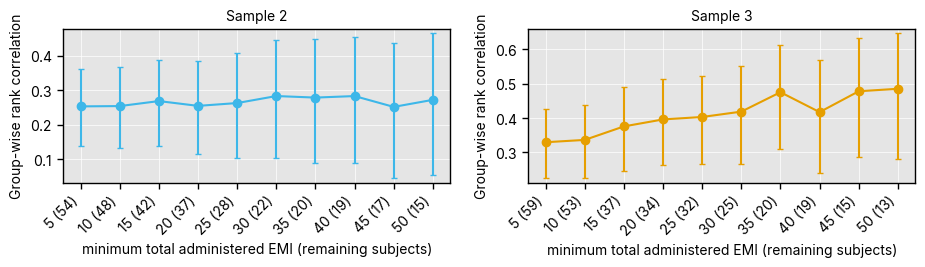

In [ ]:
import sys
sys.path.append('..')
import pandas as pd
import torch as tc
import matplotlib.pyplot as plt
from plotting_styles import PaperStyle, colors
import statsmodels.api as sm
from statsmodels.formula.api import ols

select_model = 'all'
select_binned_policy = 'ignore'
select_x0 = 'all'

with PaperStyle():

    fig, axes = plt.subplots(1, 2, figsize=(11,2))    
    
    for m, mrt in enumerate(MRT):
        
        plrnn_emi_rank = plrnn_emi_cir.loc[(mrt, select_model, select_x0)]
        total_emis = emi_occurrences.loc[mrt].sum(axis=1).loc[plrnn_emi_rank.index]
        effects_rank = effects.loc[(mrt, select_binned_policy)].loc[plrnn_emi_rank.index]
        emi_occurrences_loc = emi_occurrences.loc[mrt].loc[plrnn_emi_rank.index]
        
        group_wise_effects = []
        n_participants_remaining = []

        bins = np.arange(5, 51, 5)
        correlations_over_bins = []
        
        for i in bins:
            correlations = weight_corr_for_dataframes(plrnn_emi_rank.loc[total_emis>=i], 
                                                      effects_rank.loc[total_emis>=i], 
                                                      emi_occurrences_loc.loc[total_emis>=i], method='spearman', axis=1, B=2, alternative='greater', 
                                                    p_method='permutation', ci_type='percentile')
            correlations_over_bins.append(correlations['statistic'].dropna())
            overall_effect = meta_spearman(correlations['statistic'].dropna(), None)
            group_wise_effects.append(overall_effect)
            n_participants_remaining.append(len(correlations.dropna()))

        group_wise_effects = pd.DataFrame(group_wise_effects)
        group_wise_effects.plot(ax=axes[m], y='effect', yerr=[group_wise_effects['effect']-group_wise_effects['ci_lower'], group_wise_effects['ci_upper']-group_wise_effects['effect']], 
                                marker='o', legend=False, title=f'Sample {mrt}', color=colors.color_cycle[m])
        axes[m].set_xticks(range(len(bins)), [f'{b} ({n})' for b, n in zip(bins, n_participants_remaining)], rotation=45, ha='right')
        axes[m].set(xlabel='minimum total administered EMI (remaining subjects)', ylabel='Group-wise rank correlation')
        plotting_utils.adjust_ylim(axes[m], top=0.03, bottom=0.03)

        correlations_over_bins_molten = pd.concat(correlations_over_bins, axis=1, keys=bins, names='min_EMI').melt().dropna().astype(float)
        model = ols('value ~ C(min_EMI)', data=correlations_over_bins_molten).fit()
        anova_table = sm.stats.anova_lm(model, typ=1)
        print(f'ANOVA results for Sample {mrt}:')
        print(anova_table)
        
    
    if SAVE:
        plt.savefig(data_utils.join_ordinal_bptt_path('results', '_paper', f'emi_rank_correlation_by_number_administered_emi.svg'))
    plt.show()

ANOVA results for both Samples:
               df     sum_sq   mean_sq         F    PR(>F)
C(min_EMI)    9.0   0.393462  0.043718  0.284284  0.978998
Residual    599.0  92.115848  0.153783       NaN       NaN


<Figure size 640x480 with 0 Axes>

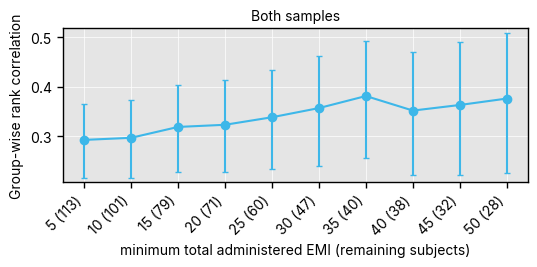

In [25]:
import sys
sys.path.append('..')
import pandas as pd
import torch as tc
import matplotlib.pyplot as plt
from plotting_styles import PaperStyle, colors
import statsmodels.api as sm
from statsmodels.formula.api import ols

select_model = 'all'
select_binned_policy = 'ignore'
select_x0 = 'all'

with PaperStyle():

    fig, ax = plt.subplots(1, 1, figsize=(6,2))

    idx = pd.IndexSlice            
    plrnn_emi_rank = plrnn_emi_cir.loc[idx[:, select_model, select_x0]]
    total_emis = emi_occurrences.loc[plrnn_emi_rank.index].sum(axis=1)
    effects_rank = effects.loc[idx[:, select_binned_policy, :]].loc[plrnn_emi_rank.index]
    emi_occurrences_loc = emi_occurrences.loc[plrnn_emi_rank.index]
    
    group_wise_effects = []
    n_participants_remaining = []

    bins = np.arange(5, 51, 5)
    correlations_over_bins = []
    
    for i in bins:
        correlations = weight_corr_for_dataframes(plrnn_emi_rank.loc[total_emis>=i], 
                                                    effects_rank.loc[total_emis>=i], 
                                                    emi_occurrences_loc.loc[total_emis>=i], method='spearman', axis=1, B=2, alternative='greater', 
                                                p_method='permutation', ci_type='percentile')
        correlations_over_bins.append(correlations['statistic'].dropna())
        overall_effect = meta_spearman(correlations['statistic'].dropna(), None)
        group_wise_effects.append(overall_effect)
        n_participants_remaining.append(len(correlations.dropna()))

    group_wise_effects = pd.DataFrame(group_wise_effects)
    group_wise_effects.plot(ax=ax, y='effect', yerr=[group_wise_effects['effect']-group_wise_effects['ci_lower'], group_wise_effects['ci_upper']-group_wise_effects['effect']], 
                            marker='o', legend=False, title=f'Both samples')
    ax.set_xticks(range(len(bins)), [f'{b} ({n})' for b, n in zip(bins, n_participants_remaining)], rotation=45, ha='right')
    ax.set(xlabel='minimum total administered EMI (remaining subjects)', ylabel='Group-wise rank correlation')
    plotting_utils.adjust_ylim(ax, top=0.03, bottom=0.03)

    correlations_over_bins_molten = pd.concat(correlations_over_bins, axis=1, keys=bins, names='min_EMI').melt().dropna().astype(float)
    model = ols('value ~ C(min_EMI)', data=correlations_over_bins_molten).fit()
    anova_table = sm.stats.anova_lm(model, typ=1)
    print(f'ANOVA results for both Samples:')
    print(anova_table)        
    
    if SAVE:
        plt.savefig(data_utils.join_ordinal_bptt_path('results', '_paper', f'emi_rank_correlation_by_number_administered_emi_both_mrt.svg'))
    plt.show()

Plot the permutation of ranks

/export/home/jfechtel/miniconda3/envs/reallaborai4u/lib/python3.13/site-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]


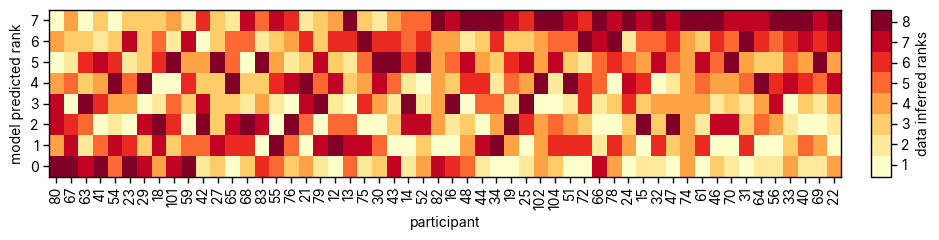

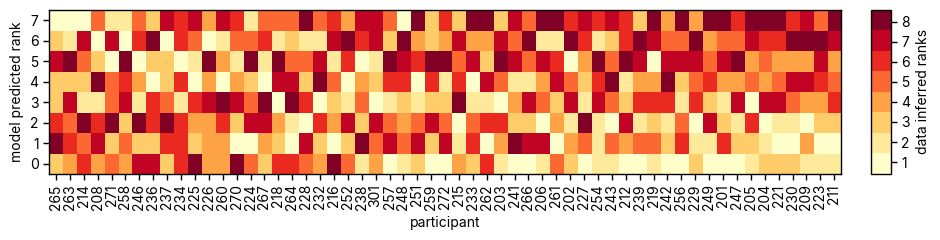

In [34]:
import matplotlib.pyplot as plt
from plotting_utils import discretized_colormap, subplots_with_colorbar
from plotting_styles import PaperStyle
import numpy as np

choose_model = 'all'
choose_binned_policy = 'ignore'
choose_x0 = 'all'

with PaperStyle(settings={'axes.grid':False}):
    L = len(INTERACTIVE_NAMES)
    cmap = discretized_colormap('YlOrRd', L)
    for mrt in MRT:
        plrnn_emi_rank = plrnn_emi_cir.loc[(mrt, choose_model, choose_x0)].rank(1)
        effects_rank = effects.loc[(mrt, choose_binned_policy)].rank(1)
        correlations = plrnn_emi_rank.corrwith(effects_rank, axis=1, method='spearman')
        participant_order = correlations.sort_values().dropna().index
        participant_order = participant_order.drop([231, 269], errors='ignore')
        reordered_ranks = np.zeros((len(participant_order), L))
        for j, p in enumerate(participant_order):
            reordered_ranks[j] = effects_rank.loc[p].loc[plrnn_emi_rank.loc[p].sort_values().index].to_numpy()

        fig, ax = subplots_with_colorbar(reordered_ranks.T, nrows=1, cmap=cmap, aspect='auto', axes_pad=1.5, cbar_size='2.5%',
                                        figsize=(9.5,2.5), cbar_ticks=np.linspace(1.5, L-0.5, L), cbar_ticklabels=range(1,L+1),
                                        image_grid_aspect=False)

        ax[0].set_xlabel('participant')
        ax[0].set_ylabel('model predicted rank')
        ax[0].set_xticks(range(len(participant_order)), labels=participant_order, rotation=90)
        ax[0].set_yticks(range(L), labels=np.arange(L))
        # ax[0].set_title(f'MRT{mrt} permuted data inferred ranks')
        ax[0].cax.set_ylabel('data inferred ranks')
        # for pi, p in enumerate(participants):
        #     ordered_intervs = model_ranks.loc[p].argsort().to_numpy() + 1
        #     for ii, i in enumerate(intervention_names):
        #         ax[1].annotate(str(ordered_intervs[ii]), (pi,ii))

        plt.tight_layout()
        if SAVE:
            plt.savefig(data_utils.join_ordinal_bptt_path('results', '_paper', f'permuted_ranks_mrt{mrt}.svg'))
    plt.show()

Plot both underneath each other, for both MRTs in one single plot

Dropped [73]


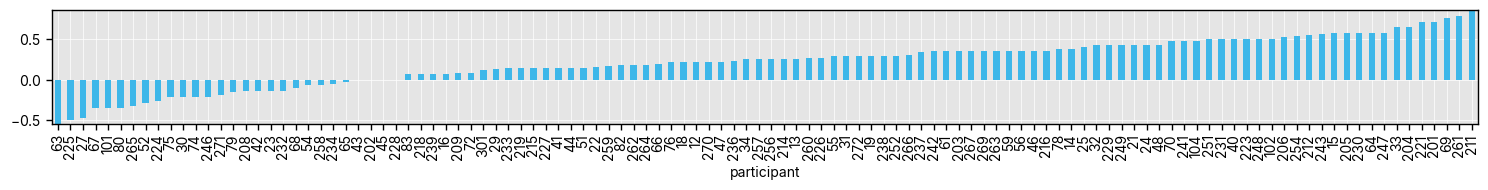

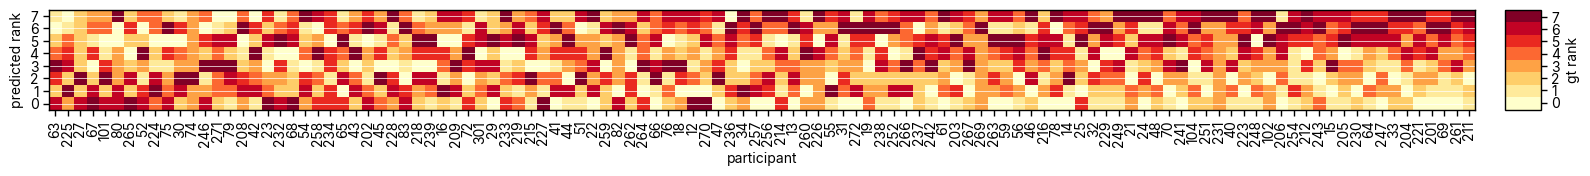

In [16]:
import sys
sys.path.append('..')
import pandas as pd
import torch as tc
import matplotlib.pyplot as plt
from plotting_styles import PaperStyle

correlations = []
with PaperStyle():
    fig, ax = plt.subplots(1, 1, figsize=(15,2))
    # for m, mrt in enumerate(MRT):
    plrnn_emi_rank = plrnn_emi_cir.loc[(pd.IndexSlice[:], model, x0), :].droplevel(['MRT', 'model', 'x0']).rank(1)-1
    effects_rank = effects.loc[(pd.IndexSlice[:], binned_policy), :].droplevel(['MRT', 'binned_policy']).rank(1)-1
    correlations.append(plrnn_emi_rank.corrwith(effects_rank, axis=1, method='kendall'))

    correlations = pd.concat(correlations, axis=0).sort_index()
    participant_order = correlations.sort_values().dropna().index
    dropped = correlations.loc[correlations.isna()].index.to_list()
    if len(dropped) > 0:
        print(f'Dropped {dropped}')
    correlations.loc[participant_order].plot(ax=ax, kind='bar', rot=90)
    plt.tight_layout()
    plt.savefig(data_utils.join_ordinal_bptt_path('results', f'_paper', 'correlation_ranks.png'), dpi=300)

    reordered_ranks = np.zeros((len(participant_order), L))
    for j, p in enumerate(participant_order):
        reordered_ranks[j] = effects_rank.loc[p].loc[plrnn_emi_rank.loc[p].sort_values().index].to_numpy()

    fig, ax = subplots_with_colorbar(reordered_ranks.T, nrows=1, cmap=cmap, aspect='auto', axes_pad=1.5, cbar_size='2.5%',
                                    figsize=(16,7), cbar_ticks=np.linspace(0.5, L-1.5, L), cbar_ticklabels=range(L))

    ax[0].set_xlabel('participant')
    ax[0].set_ylabel('predicted rank')
    ax[0].set_xticks(range(len(participant_order)), labels=participant_order, rotation=90)
    ax[0].set_yticks(range(L), labels=np.arange(L))
    ax[0].cax.set_ylabel('gt rank')

    plt.tight_layout()
    if SAVE:
        plt.savefig(data_utils.join_ordinal_bptt_path('results', f'_paper', 'correlation_ranks_permutation.png'), dpi=300)

    plt.show()

We can also visualize this as a scatter plot between predicted and actual effect, and calculate Kendall's tau

In [21]:
import seaborn as sns
from scipy import stats

participant_effects = effects.copy()
for p in include_subj:
    participant_effects.loc[p] = get_proximal_effects(p, until_timestep=until_timestep[p])
joint_df = pd.concat((effects.stack(), participant_effects.loc[include_subj].stack()), axis=1)
joint_df = joint_df.reset_index()
joint_df.columns = ('participant', 'intervention', 'model predicted', 'data inferred')
joint_df['intervention'] = joint_df['intervention'].str.slice(-1)
tau = joint_df.groupby('participant').corr(method='kendall')['model predicted'].xs('data inferred', level=1)

fig, axes = plt.subplots(1,3, figsize=(14,4))
sns.scatterplot(data=joint_df, x='model predicted', y='data inferred', hue='participant', ax=axes[0])
axes[0].set_title('proximal effect scores')
sns.scatterplot(data=joint_df, x='model predicted', y='data inferred', hue='intervention', ax=axes[1])
axes[1].set_title('proximal effect scores')
axes[2].bar(tau.index, tau)
axes[2].set_title('Kendall rank correlation')

axes[2].set_xlabel('participant')

NameError: name 'include_subj' is not defined

Sanity check that random permutations of ranks produce on average 0 correlation

In [20]:
from scipy.stats import spearmanr, kendalltau
Z = np.arange(8)
r = 0
for i in range(10000):
    P = np.random.permutation(8)
    r += kendalltau(Z, P).correlation
r /= 10000
print(r)


0.002485714285714282


In [17]:
import numpy as np
from itertools import combinations
from scipy.stats import rankdata, norm

# ---------- Weighted stats ----------
def weighted_mean(a, w):
    return np.sum(w*a) / np.sum(w)

def weighted_corr(x, y, w):
    # Weighted Pearson
    if len(w)==0:
        return np.nan
    xm = weighted_mean(x, w); ym = weighted_mean(y, w)
    cov = np.sum(w*(x-xm)*(y-ym)) / np.sum(w)
    vx  = np.sum(w*(x-xm)**2)     / np.sum(w)
    vy  = np.sum(w*(y-ym)**2)     / np.sum(w)
    if vx*vy == 0:
        return np.nan
    return cov / np.sqrt(vx*vy)

def weighted_spearman(x, y, w):
    rx = rankdata(x, method='average')
    ry = rankdata(y, method='average')
    return weighted_corr(rx, ry, w)

def weighted_kendall(x, y, w):
    C = D = T = 0.0
    n = len(x)
    for i, j in combinations(range(n), 2):
        wij = w[i]*w[j]
        s = np.sign(x[i]-x[j]) * np.sign(y[i]-y[j])
        if s > 0: C += wij
        elif s < 0: D += wij
        T += wij
    return (C - D) / T


def ci_pvalue_weighted_rank_onepass(xbar, xhat, w, method="spearman",
                                    B=10000, alpha=0.05, alternative='two-sided', seed=0,
                                    p_method="bootstrap", ci_type='percentile', theta0 = 0.0, clip_ci=False,
                                    nan_policy="propagate"):  # "bootstrap" or "permutation"
    rng = np.random.default_rng(seed)
    xbar = np.asarray(xbar); xhat = np.asarray(xhat); w = np.asarray(w)
    if nan_policy == "omit":
        mask = np.isfinite(xbar) & np.isfinite(xhat) & np.isfinite(w)
        xbar = xbar[mask]
        xhat = xhat[mask]
        w = w[mask]
    elif nan_policy == "raise":
        if not (np.isfinite(xbar).all() and np.isfinite(xhat).all() and np.isfinite(w).all()):
            raise ValueError("Input contains NaN or Inf")
    elif nan_policy == "propagate":
        if not (np.isfinite(xbar).all() and np.isfinite(xhat).all() and np.isfinite(w).all()):
            return {
                "statistic": np.nan,
                "ci_lower": np.nan,
                "ci_upper": np.nan,
                "p_value": np.nan,
                "p_method": None,
                "B": B,
                "alpha": alpha,
                "alternative": alternative,
                "theta0": theta0,
                "method": f"weighted {method.lower()}"
            }
    n = len(xbar)
    if method.lower() == 'pearson':
        stat_fn = weighted_corr
    elif method.lower().startswith("spear"):
        stat_fn = weighted_spearman
    elif method.lower().startswith("kendall"):
        stat_fn = weighted_kendall
    else:
        raise ValueError(f"Unknown method: {method}")
    if w is None:
        w = np.ones_like(xbar)

    obs = stat_fn(xbar, xhat, w)

    boot_stats = np.empty(B)
    perm_stats = np.empty(B) if p_method=="permutation" else None

    for b in range(B):
        # Bootstrap (groups) for CI and bootstrap-based p
        idx = rng.integers(0, n, n)
        boot_stats[b] = stat_fn(xbar[idx], xhat[idx], w[idx])

        # Optional: permutation stream for permutation p
        if p_method == "permutation":
            perm = rng.permutation(n)
            # weights stay with groups; permute predictions
            perm_stats[b] = stat_fn(xbar, xhat[perm], w)

    # Percentile CI    

    # ---- CI (choose flavor) ----
    q_lo, q_hi = np.percentile(boot_stats, [100*alpha/2, 100*(1-alpha/2)])
    if ci_type == "percentile":
        lo, hi = (q_lo, q_hi)
    elif ci_type == "basic":
        # basic CI: [2*obs - q_hi, 2*obs - q_lo]
        lo, hi = (2*obs - q_hi, 2*obs - q_lo)
        if clip_ci:
            lo = max(lo, -1.0)
            hi = min(hi, 1.0)
    else:
        raise ValueError("ci_type must be 'percentile' or 'basic'.")
    lo = np.min((lo, obs))
    hi = np.max((hi, obs))

    # ---- p-value (matched to CI type, unless permutation) ----
    alt = alternative.lower()
    if p_method == "permutation":
        if alt == "two-sided":
            p = (np.sum(np.abs(perm_stats - theta0) >= np.abs(obs - theta0)) + 1) / (B + 1)
        elif alt == "greater":
            p = (np.sum(perm_stats >= obs) + 1) / (B + 1)
        elif alt == "less":
            p = (np.sum(perm_stats <= obs) + 1) / (B + 1)
        else:
            raise ValueError("alternative must be 'two-sided', 'greater', or 'less'")
        p_note = "permutation p-value (null: no association)"
    else:
        if ci_type == "percentile":
            # Percentile-aligned p: compare theta0 directly to bootstrap dist
            left  = np.mean(boot_stats <= theta0)
            right = np.mean(boot_stats >= theta0)
            if alt == "two-sided":
                p = 2 * min(left, right)
            elif alt == "greater":
                p = right
            elif alt == "less":
                p = left
            else:
                raise ValueError("alternative must be 'two-sided', 'greater', or 'less'")
            p_note = "bootstrap percentile p-value (aligned with percentile CI)"
        else:  # basic
            # Basic-aligned p: pivot via cutoff = 2*obs - theta0
            cutoff = 2*obs - theta0
            left  = np.mean(boot_stats <= cutoff)
            right = np.mean(boot_stats >= cutoff)
            if alt == "two-sided":
                p = 2 * min(left, right)
            elif alt == "greater":
                p = right
            elif alt == "less":
                p = left
            else:
                raise ValueError("alternative must be 'two-sided', 'greater', or 'less'")
            p_note = "bootstrap basic p-value (aligned with basic CI)"
        p = float(min(1.0, max(0.0, p)))  # clamp to [0,1]


    return {
        "statistic": obs,
        "ci_lower": lo,
        "ci_upper": hi,
        "p_value": float(p),
        "p_method": p_note,
        "B": B,
        "alpha": alpha,
        "alternative": alternative,
        "theta0": theta0,
        "method": f"weighted {method.lower()}"
    }


def weight_corr_for_dataframes2(df1, df2, weights, method="spearman", axis=0, **kwargs):
    assert df1.shape == df2.shape
    if weights is None:
        weights = pd.DataFrame(1, index=df1.index, columns=df1.columns)
    assert df1.shape[0] == weights.shape[0]
    if axis == 1:
        df1 = df1.T
        df2 = df2.T
        weights = weights.T
    results = pd.DataFrame(index=df1.columns, columns=['statistic', 'ci_lower', 'ci_upper', 'p_value'])    
    for col in df1.columns:
        res = ci_pvalue_weighted_rank_onepass(df1[col], df2[col], weights[col], method=method, **kwargs)
        results.loc[col] = [res['statistic'], res['ci_lower'], res['ci_upper'], res['p_value']]
    return results


def meta_spearman(rhos, m, alpha=0.05):
    rhos = np.asarray(rhos, float)
    if m is None:
        m = np.full_like(rhos, 8, dtype=float)  # number of groups per participant
    z = np.arctanh(np.clip(rhos, -0.999999, 0.999999))
    w = np.maximum(m - 3, 1e-9)                # inverse Var(z)
    zbar = np.sum(w * z) / np.sum(w)
    se = 1 / np.sqrt(np.sum(w))
    zlo, zhi = zbar + norm.ppf([alpha/2, 1-alpha/2]) * se
    r_pooled = np.tanh(zbar)
    ci = (np.tanh(zlo), np.tanh(zhi))
    zstat = zbar / se
    p = 2 * (1 - norm.cdf(abs(zstat)))
    return dict(effect=r_pooled, ci_lower=ci[0], ci_upper=ci[1], p=p)